### cell communication analysis
This notebook demonstrate:
1. Niches (Brickman Raredon, et al, 2022) 
For spatial transcriptome data, limiting the nearest neighbor per cell to k, we construct two matrices, cell-cell matrix and neighbors-cell matrix. The element of cell-cell matrix is determined by multiplying the ligand expression of the sending cell and the receptor expression of the receiving cell, also we provide the weighted knn, multiply that by the inverse of the distance. However, neighbors-cell matrix, defined as the signaling input to a cell, determined by taking the geometric mean of the ligand profiles of the surrounding cells and the receptor profile of the receiving cell. 
2. NicheNet (Browaeys, et al, 2020)
We use the prior model in NicheNet, ligand target matrix and ligand receptor network are used to analysis cell interactions.

In [1]:
import sys
import os
sys.path.append('/zfs-1/zuolulu/spateo-release')
import spateo as st
import dynamo as dyn
import scanpy as sc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import anndata

/home/zuolulu/anaconda3/envs/spateo-new/lib/python3.8/site-packages/geopandas-0.10.2-py3.8.egg/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


### Load data 
Here, we use the ICC tumor(border)data to perform the niches (ligand-receptor) interaction analysis.

In [2]:
os.chdir('/zfs-1/zuolulu/spatialDEG/test/03.ICC_tumor_border/')
os.getcwd()

'/zfs-1/zuolulu/spatialDEG/test/03.ICC_tumor_border'

In [4]:
adata = anndata.read('adata_bin50_scc_cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 45923 × 37634
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_counts', 'scc'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'neighbors', 'scc', 'scc_colors', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'bbox', 'contour', 'spatial'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

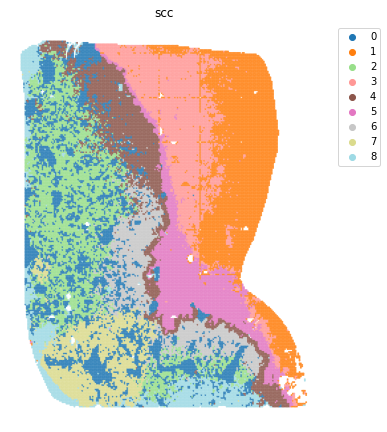

In [5]:
st.pl.space(adata, color=['scc'], pointsize=0.2, show_legend="upper left",theme='blue')

In [3]:
adata_border = anndata.read('ICC_border.h5ad')
adata_border

AnnData object with n_obs × n_vars = 14723 × 37634
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_counts', 'scc'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'neighbors', 'scc', 'scc_colors', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'bbox', 'contour', 'spatial'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

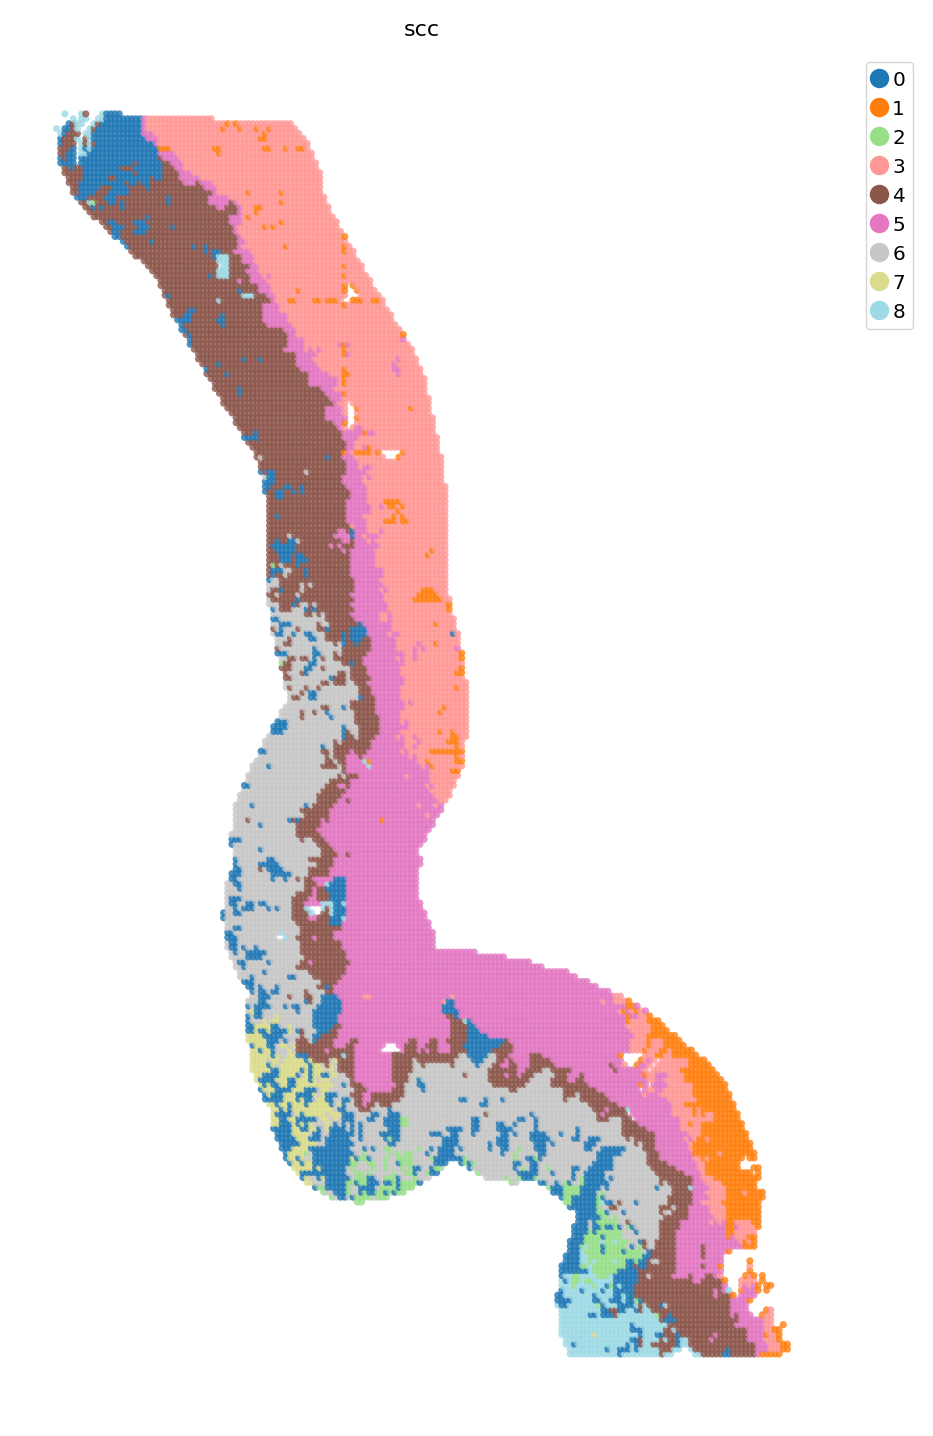

In [120]:
st.pl.space(adata_border, color=['scc'], pointsize=0.2, show_legend="upper left",theme='blue')

### Niche analysis 

In [77]:
adata_border = dyn.tl.neighbors(adata_border, n_neighbors=30, basis='pca', result_prefix="spatial")
path = '/zfs-1/zuolulu/spatialDEG/test/NicheNet_matrix/'
import cell_communication
adata_n2c = cell_communication.niches(adata_border,path=path,weighted=False,species='human',system='niches_n2c')
adata_n2c.obs['cell_pair_name'] = adata_border.obs_names.tolist()
adata_n2c.obsm['spatial'] = adata_border.obsm['spatial']
adata_n2c.write_h5ad('ICC_border_n2c.h5ad')

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.


In [136]:
#adata_n2c= anndata.read('ICC_border_n2c_cluster.h5ad')
#adata_n2c= anndata.read('ICC_border_n2c.h5ad')
#adata_n2c= anndata.read('ICC_border_n2c_cluster_fillter.h5ad')
#adata_n2c

AnnData object with n_obs × n_vars = 14723 × 10175
    obs: 'cell_pair_name'
    obsm: 'spatial'

In [137]:
adata_n2c = st.pp.filter.filter_genes(adata_n2c, max_cells=adata_n2c.n_obs*0.95) #filter QC
adata_n2c.uns["pp"] = {}
adata_n2c.var_names_make_unique()
dyn.pp.normalize_cell_expr_by_size_factors(adata_n2c, layers="X")
dyn.pp.log1p(adata_n2c)
st.tl.pca_spateo(adata_n2c, n_pca_components=30)
dyn.tl.neighbors(adata_n2c, n_neighbors=20)

|-----> Runing PCA on adata.X...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.


In [138]:
adata_n2c

AnnData object with n_obs × n_vars = 14723 × 128
    obs: 'cell_pair_name'
    var: 'pass_basic_filter'
    uns: 'pp', 'log1p', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [6]:
dyn.tl.leiden(adata_n2c,key_added="leiden",resolution=1) #leiden
#dyn.tl.louvain(adata_n2c,key_added="louvain",resolution=1) #louvain
#st.tl.scc(adata_n2c, s_neigh=30, resolution=0.9, cluster_method="louvain", key_added="scc", pca_key="X_pca")

|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> using adj_matrix from arg for clustering...
|-----> Detecting communities on graph...
|-----

|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type


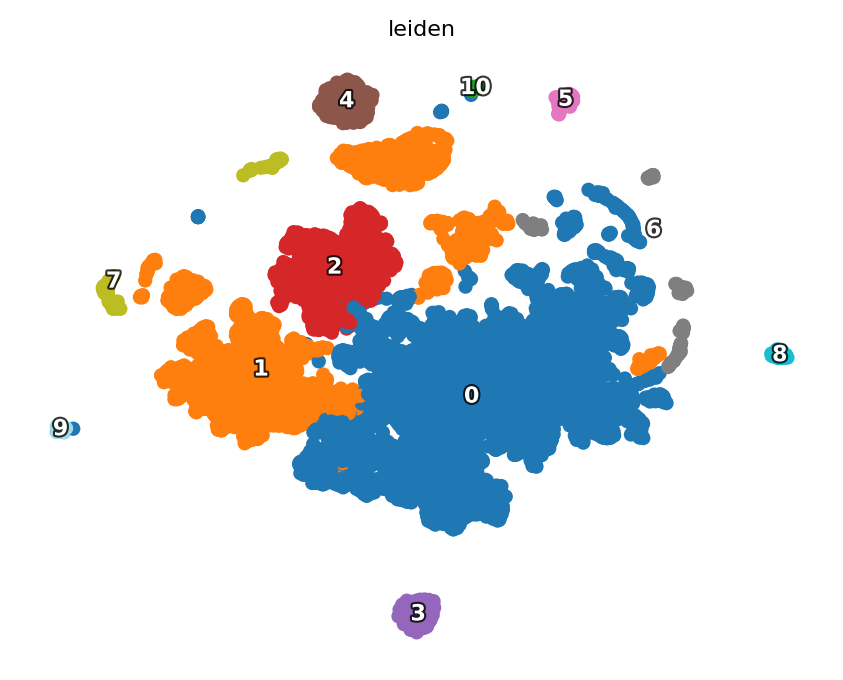

In [142]:
dyn.pl.umap(adata_n2c, color=['leiden'],pointsize=0.2, alpha = 1,theme='blue',save_show_or_return='show')

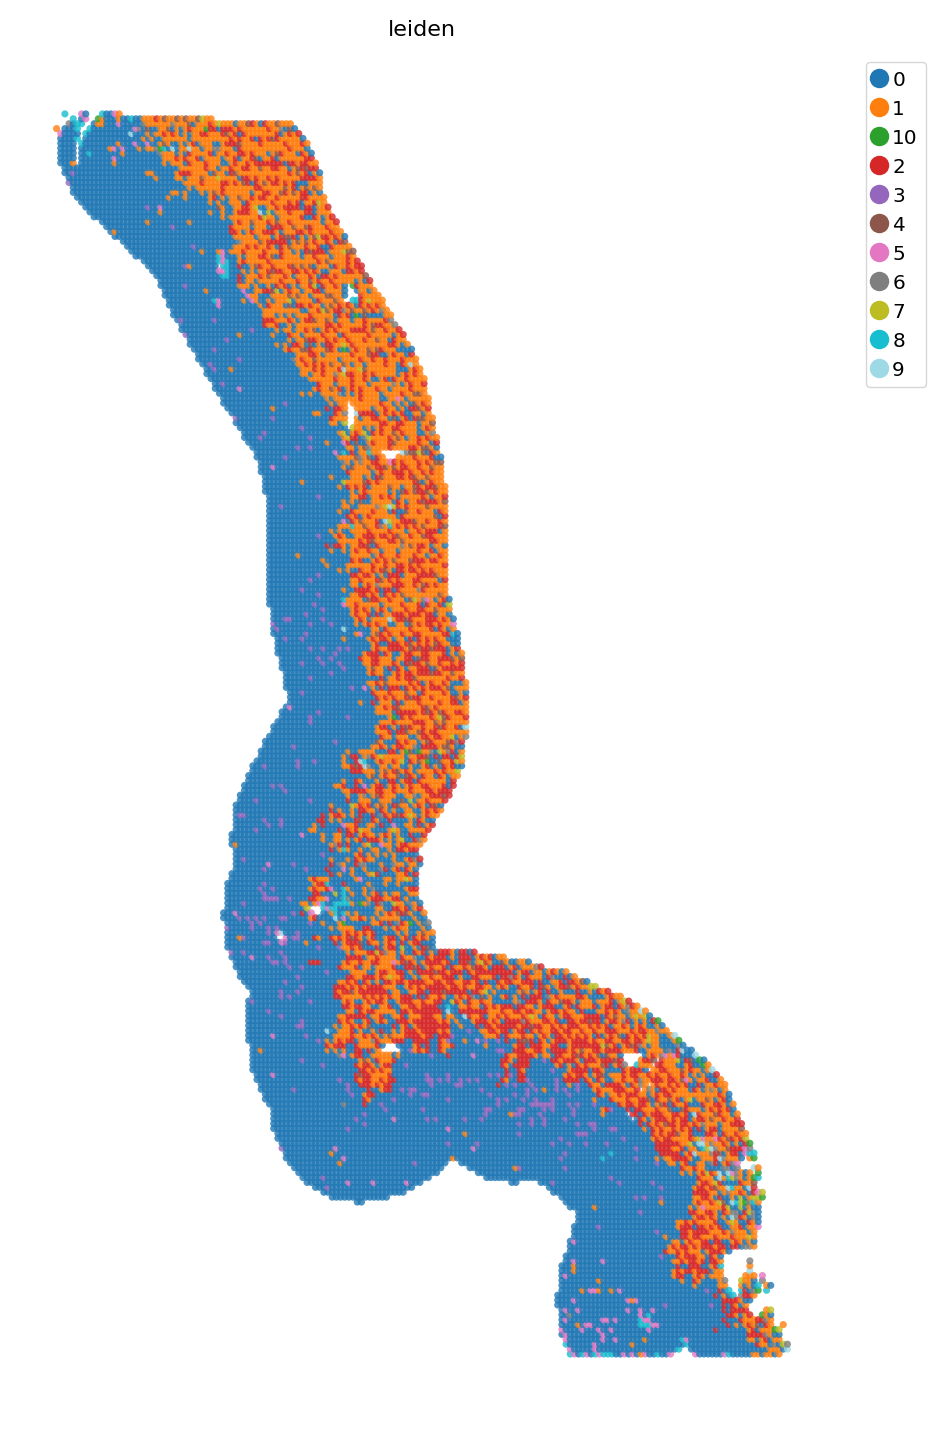

In [143]:
st.pl.space(adata_n2c, color=['leiden'], pointsize=0.2, show_legend="upper left",theme='blue')

In [146]:
adata_n2c = st.tl.find_all_cluster_degs(adata_n2c,group='leiden',genes=None)
marker_genes_dict = st.tl.top_n_degs(adata_n2c,group='leiden')
marker_genes_dict

identifying top markers for each group: 128it [00:00, 169.04it/s]

{'0': ['PTPRF-RACK1',
  'RTN4-LINGO1',
  'APP-LINGO1',
  'FN1-IGF2R',
  'CDH1-RACK1',
  'ITGB1-IGF2R',
  'ITGB1-RACK1',
  'PTPRM-RACK1',
  'LAMB1-PTPRF',
  'CDH1-PTPRF'],
 '1': ['F2-VTN', 'C5-VTN', 'APOB-IGF2R', 'TF-IGF2R', 'EFEMP1-VTN'],
 '2': ['IGF2-VTN',
  'IGF2-IGF2R',
  'F2-VTN',
  'C5-VTN',
  'EFEMP1-VTN',
  'TNFRSF11B-VTN',
  'APOB-IGF2R',
  'VEGFA-VTN',
  'TF-IGF2R',
  'ITGB1-VTN'],
 '3': ['RPS19-RPSA',
  'FN1-RPSA',
  'CALM1-RPSA',
  'PROS1-RPSA',
  'LAMB2-RPSA',
  'CDH1-PTPRF',
  'LAMB1-PTPRF',
  'ANXA1-PTPRF',
  'APOB-PTPRF',
  'PTPRF-RACK1'],
 '4': ['F2-VTN', 'APOB-IGF2R', 'TF-IGF2R'],
 '6': ['TF-IGF2R', 'FN1-IGF2R'],
 '7': ['APOB-IGF2R', 'TF-IGF2R']}

In [147]:
deg_table = st.tl.top_n_degs(adata_n2c,group='leiden',only_deg_list = False,sort_by='cosine_score',top_n_genes=15)
deg_table

gene test_group                    control_group  \
test_group                                                                 
0          4     PTPRF-RACK1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           0     RTN4-LINGO1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           2      APP-LINGO1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           1       FN1-IGF2R          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           3      CDH1-RACK1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           5     ITGB1-IGF2R          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           6     ITGB1-RACK1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           7     PTPRM-RACK1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           8     LAMB1-PTPRF          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           9      CDH1-PTPRF          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           12   CLSTN1-IGF2R          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           11    AIMP1-RACK1          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           10    LAMA1-PTPRF          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           13    VCAM1-IGF2R          0  [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
1          2          F2-VTN          1  [0, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           3          C5-VTN          1  [0, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           1      APOB-IGF2R          1  [0, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           0        TF-IGF2R          1  [0, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
           4      EFEMP1-VTN          1  [0, 10, 2, 3, 4, 5, 6, 7, 8, 9]   
2          2        IGF2-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           0      IGF2-IGF2R          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           1          F2-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           3          C5-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           6      EFEMP1-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           8   TNFRSF11B-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           5      APOB-IGF2R          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           7       VEGFA-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           4        TF-IGF2R          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
           9       ITGB1-VTN          2  [0, 1, 10, 3, 4, 5, 6, 7, 8, 9]   
3          1      RPS19-RPSA          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           3        FN1-RPSA          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           0      CALM1-RPSA          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           4      PROS1-RPSA          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           2      LAMB2-RPSA          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           5      CDH1-PTPRF          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           6     LAMB1-PTPRF          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           10    ANXA1-PTPRF          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           9      APOB-PTPRF          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           8     PTPRF-RACK1          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           7      CDH1-RACK1          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           12    LAMA1-PTPRF          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           11    PTPRM-RACK1          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           13    AIMP1-RACK1          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
           15    RTN4-LINGO1          3  [0, 1, 10, 2, 4, 5, 6, 7, 8, 9]   
4          0          F2-VTN          4  [0, 1, 10, 2, 3, 5, 6, 7, 8, 9]   
           2      APOB-IGF2R          4  [0, 1, 10, 2, 3, 5, 6, 7, 8, 9]   
           1        TF-IGF2R          4  [0, 1, 10, 2, 3, 5, 6, 7, 8, 9]   
6          0        TF-IGF2R          6  [0, 1, 10, 2, 3, 4, 5, 7, 8, 9]   
           1       FN1-IGF2R          6  [0, 1, 10, 2, 3, 4, 5, 7, 8, 9]   
7          0      APOB-IGF2R          7  [0, 1, 10, 2, 3, 4, 5, 6, 8, 9]   
           1        TF-IGF2R          7  [0, 1, 10, 2, 3, 4, 5, 6, 8, 9]

In [148]:
markers = deg_table['gene'].unique().tolist()
adata_n2c.var_names_make_unique()
adata_n2c.layers['scaled'] = sc.pp.scale(adata_n2c, copy=True).X
adata_n2c.obs['leiden'] = adata_n2c.obs['leiden'].astype('category')

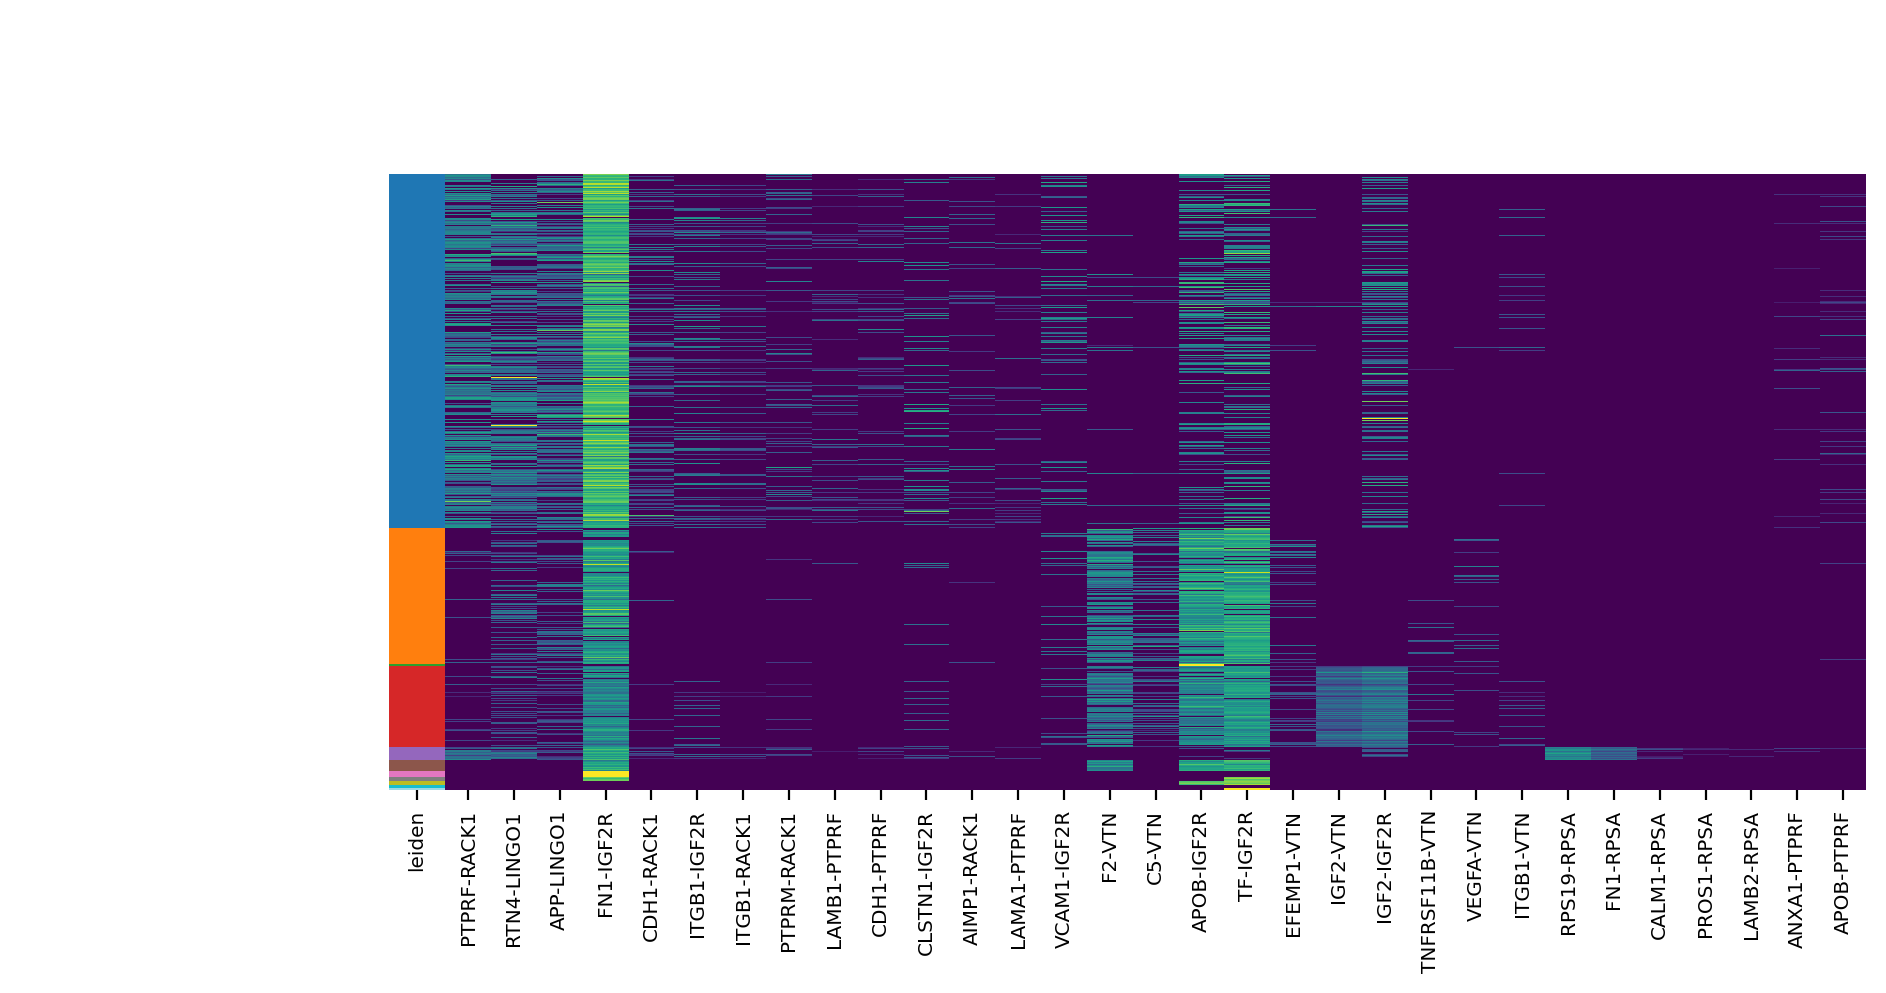

In [150]:
from spateo.plotting.static.heatmap import heatmap
heatmap(adata_n2c,markers,group='leiden',)

In [144]:
adata_n2c.write_h5ad("ICC_border_n2c_cluster.h5ad")

### NicheNet analysis 

#### 1.predict ligand activity

In [119]:
sender_cells=adata_border[adata_border.obs['scc']=='5',:].obs.index
receiver_cells=adata_border[adata_border.obs['scc']!='6',:].obs.index

In [121]:
predict_ligand_activities = st.tl.predict_ligand_activities(adata_border,path = '/zfs-1/zuolulu/spatialDEG/test/NicheNet_matrix/',sender_cells=sender_cells, receiver_cells=receiver_cells, species= "human",)
predict_ligand_activities.to_csv("border_predict_ligand_activity.csv")

In [122]:
predict_ligand_activities.sort_values(by="pearson_coef", axis=0, ascending=False, inplace=True)
predict_ligand_top = predict_ligand_activities[0:20]["ligand"]
#predict_ligand_top.values.tolist()
df = predict_ligand_activities[0:20].set_index('ligand')
df = df.drop(columns='pearson_pvalue')

<AxesSubplot:ylabel='ligand'>

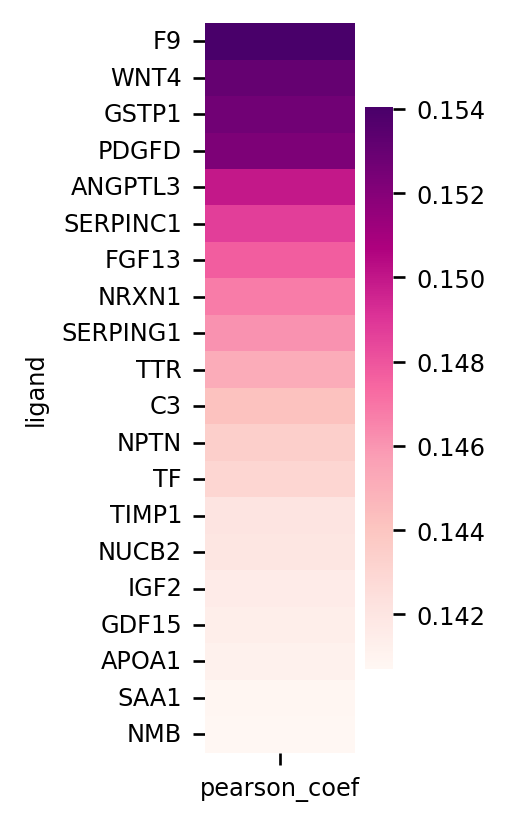

In [123]:
import seaborn as sns
import palettable
plt.figure(dpi=120,figsize=(1,4))
sns.heatmap(data=df,cmap=plt.get_cmap('RdPu'),)

#### 2. predict target genes

In [124]:
predict_target_genes = st.tl.predict_target_genes(adata_border,path='/zfs-1/zuolulu/spatialDEG/test/NicheNet_matrix/',sender_cells=sender_cells, receiver_cells=receiver_cells, species= "human",
                                                  top_ligand = 20,top_target =20,)
predict_target_genes.to_csv("border_predict_target_gene.csv")

In [125]:
predict_target_genes.rename(columns={'ligand':'ligand in Hepatocyte-1','targets':'target genes in tumor domain'},inplace=True)

In [127]:
ligand_target_mtx = predict_target_genes.pivot(index="ligand in Hepatocyte-1", columns="target genes in tumor domain", values="weights").fillna(0)

<AxesSubplot:xlabel='target genes in tumor domain', ylabel='ligand in Hepatocyte-1'>

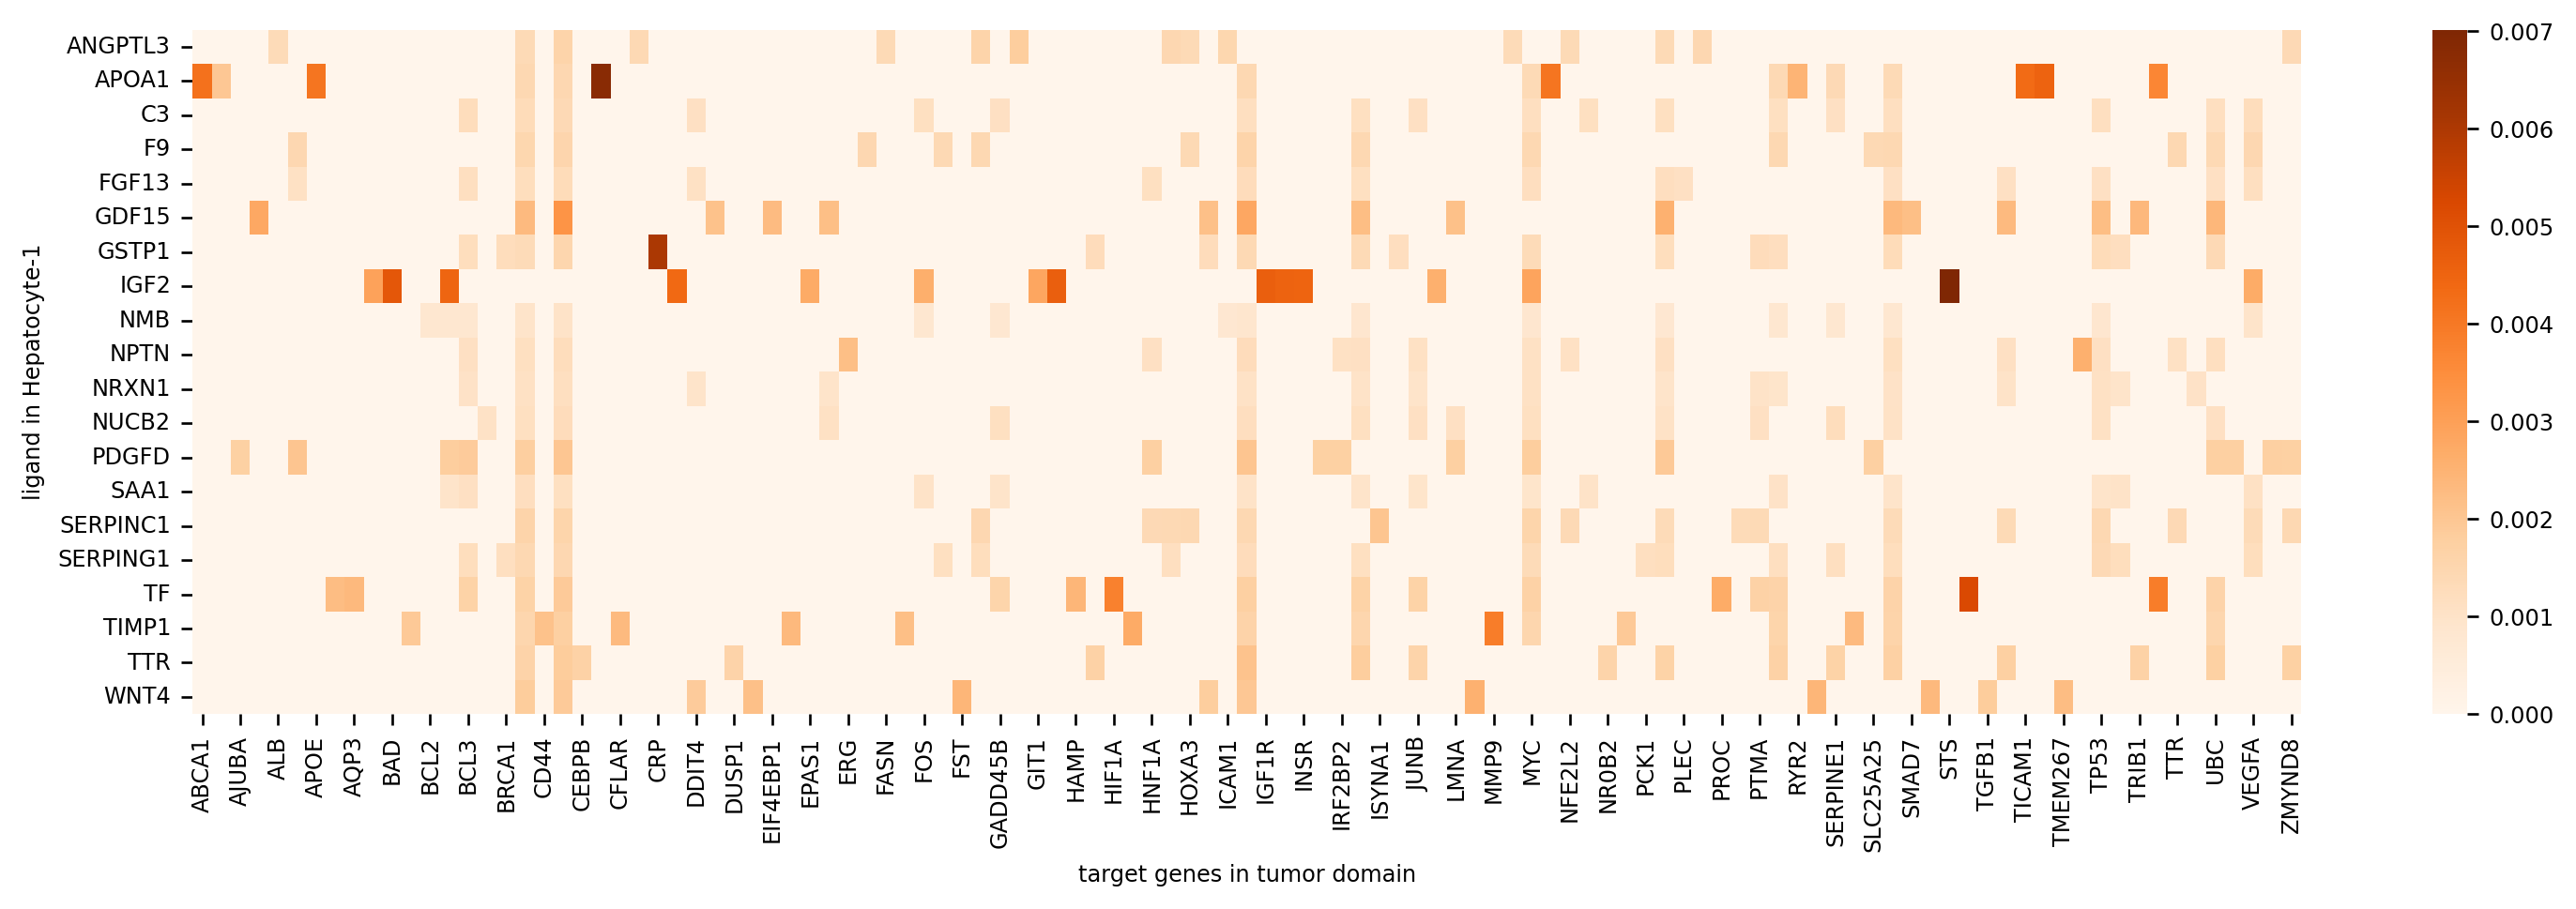

In [128]:
plt.figure(dpi=120,figsize=(15,4))
sns.heatmap(data=ligand_target_mtx,cmap=plt.get_cmap('Oranges'),)